### Importing libraries

In [ ]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.cross_decomposition import PLSRegression
from scipy.stats import pearsonr, linregress, norm
from matplotlib.ticker import MaxNLocator

### DATA IMPORT AND PREPROCESSING

In [4]:
# Import data
data = pd.read_csv('EEG_data/gen_window_lppChans.csv')
data_pz = pd.read_csv('EEG_data/gen_window_Pz.csv')

In [5]:
cond = data_pz.iloc[:, 1:4].astype(int)
amp = data_pz.iloc[:, 4:] # ERP amplitude in time window 300-1000ms

In [6]:
cond_names = cond.columns.tolist()
time_names = amp.columns.tolist()

In [7]:
# prepare X and Y
X = amp.values        # ERP amplitudes (subjects × timepoints/features)
Y = cond.values       # One-hot conditions (subjects × 3)
X.shape

(57, 350)

In [8]:
X_features = time_names
Y_features = cond_names

In [9]:
# Scale X and Center Y
scalerX = StandardScaler()
centererY = StandardScaler(with_mean=True, with_std=False)
X_scaled = scalerX.fit_transform(X)
Y_centered = centererY.fit_transform(Y)

### FIT PLS

In [10]:
n_components = 2
pls = PLSRegression(n_components=n_components, scale=False)
pls.fit(X_scaled, Y_centered)

PLSRegression(scale=False)

In [11]:
# Scores (latent variable projections)
X_scores = pls.transform(X_scaled)
Y_pred   = pls.predict(X_scaled)

In [12]:
# Singular values & covariance explained
singvals = np.zeros(n_components)
for i in range(n_components):
    cov_matrix = np.cov(X_scores[:, i], Y_pred[:, i])
    singvals[i] = cov_matrix[0, 1] * np.sqrt(X.shape[0] - 1)

cv = singvals**2 / np.sum(singvals**2) * 100
print("Covariance explained (%):", cv)

Covariance explained (%): [33.48408457 66.51591543]


### Permutation test for LV significance

In [13]:
n_permutations = 10000
perm_singvals = np.zeros((n_components, n_permutations))

In [14]:
# Run permutation tests
for perm in range(n_permutations):
    # Shuffle Y
    Y_perm = np.random.permutation(Y_centered)
    
    # Fit PLS on permuted data
    pls_perm = PLSRegression(n_components=n_components, scale=False)
    pls_perm.fit(X_scaled, Y_perm)
    
    # Get permuted scores
    X_perm_scores = pls_perm.transform(X_scaled)
    Y_perm_pred = pls_perm.predict(X_scaled)
    
    # Calculate permuted singular values
    for i in range(n_components):
        cov_matrix = np.cov(X_perm_scores[:, i], Y_perm_pred[:, i])
        perm_singvals[i, perm] = cov_matrix[0, 1] * np.sqrt(X_scaled.shape[0] - 1)
    
    if (perm + 1) % 1000 == 0:
        print(f"Completed {perm + 1} permutations")

Completed 1000 permutations
Completed 2000 permutations
Completed 3000 permutations
Completed 4000 permutations
Completed 5000 permutations
Completed 6000 permutations
Completed 7000 permutations
Completed 8000 permutations
Completed 9000 permutations
Completed 10000 permutations


In [15]:
# Calculate percentage of covariance explained in the permuted models
cv_perms = np.zeros_like(perm_singvals)
for p in range(n_permutations):
    cv_perms[:, p] = perm_singvals[:, p]**2 / np.sum(perm_singvals[:, p]**2) * 100

# Calculate p-values for each component
p_values = np.zeros(n_components)
for i in range(n_components):
    p_values[i] = (1 + np.sum(perm_singvals[i, :] > singvals[i])) / (1 + n_permutations)
p_values

array([0.70892911, 0.01419858])

In [16]:
# Print summary
print("\n--- Summary of Components ---")
for i in range(n_components):
    print(f"Component {i+1}: {cv[i]:.2f}% covariance explained, p-value = {p_values[i]:.3f}")

# Identify significant components
sig_components = np.where(p_values < 0.05)[0] + 1
print(f"\nSignificant components (p < 0.05): {sig_components}")


--- Summary of Components ---
Component 1: 33.48% covariance explained, p-value = 0.709
Component 2: 66.52% covariance explained, p-value = 0.014

Significant components (p < 0.05): [2]


In [17]:
# p-values for LVs
p_values = np.zeros(n_components)
for i in range(n_components):
    p_values[i] = (1 + np.sum(perm_singvals[i, :] > singvals[i])) / (1 + n_permutations)

In [18]:
sig_components = np.where(p_values < 0.05)[0] + 1
print("Significant components (p < 0.05):", sig_components)

Significant components (p < 0.05): [2]


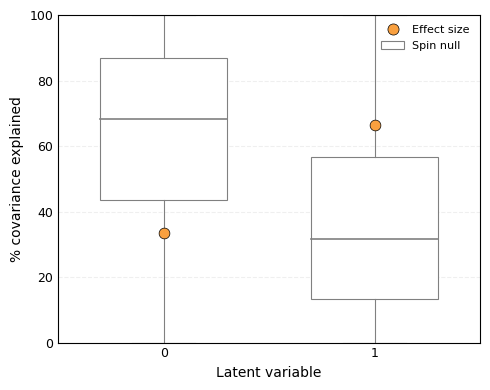

In [19]:
plt.figure(figsize=(5, 4))

box_positions = range(n_components)

boxplots = plt.boxplot(cv_perms.T, positions=box_positions, widths=0.6, 
                       patch_artist=True, 
                       boxprops=dict(facecolor='white', color='gray', linewidth=0.8),
                       whiskerprops=dict(color='gray', linewidth=0.8),
                       capprops=dict(color='gray', linewidth=0.8),
                       medianprops=dict(color='gray', linewidth=1.2),
                       flierprops=dict(marker='o', markerfacecolor='gray', markersize=3,
                                      markeredgecolor='gray', alpha=0.5))

plt.scatter(box_positions, cv, s=60, c='#F9A03F', label='Effect size', 
            edgecolor='black', linewidth=0.5, zorder=10)
plt.ylim(0, 100) 
plt.xlabel('Latent variable', fontsize=10)
plt.ylabel('% covariance explained', fontsize=10)
plt.tick_params(axis='both', which='both', direction='out', length=0)
plt.tick_params(axis='x', labelsize=9)
plt.tick_params(axis='y', labelsize=9)
plt.grid(axis='y', linestyle='--', alpha=0.2)

legend_elements = [
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='#F9A03F', 
              markersize=8, markeredgecolor='black', markeredgewidth=0.5, label='Effect size'),
    Rectangle((0, 0), 1, 1, fc='white', ec='gray', linewidth=0.8, label='Spin null')
]
plt.legend(handles=legend_elements, frameon=False, fontsize=8, loc='upper right')
plt.tight_layout()

In [22]:
Y_true_class = [np.argmax(Y[i, :]) for i in range(len(Y))]
Y_pred_class = [np.argmax(Y_pred[i, :]) for i in range(len(Y))]

In [23]:
U = pls.y_scores_  # design scores

design_score_LV2 = U[:, 1]
df = pd.DataFrame({'Condition': Y_true_class, 'LV2_design': design_score_LV2})
design_by_condition = df.groupby('Condition')['LV2_design'].mean()
print(design_by_condition)

Condition
0   -15.708388
1    30.105625
2   -14.397237
Name: LV2_design, dtype: float64


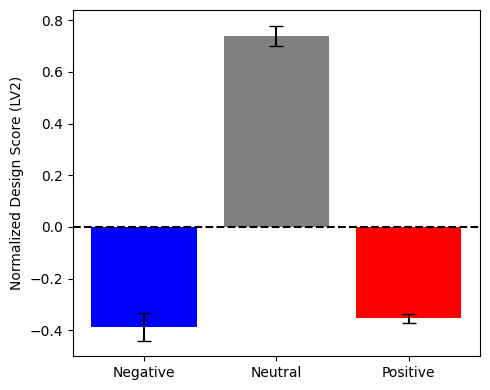

In [24]:
lv2_scores_norm = design_score_LV2 / np.max(np.abs(design_score_LV2))

# Put into a DataFrame
df = pd.DataFrame({'Condition': Y_true_class, 'LV2_design': lv2_scores_norm})

# Group by condition: mean and SEM (standard error of the mean)
group_stats = df.groupby('Condition')['LV2_design'].agg(['mean', 'sem']).reset_index()

# --- Plot ---
plt.figure(figsize=(5, 4))
plt.bar(group_stats['Condition'], group_stats['mean'], yerr=group_stats['sem'],
        color=['b', 'gray', 'r'], capsize=5)

plt.axhline(0, color='black', linestyle='--')
plt.xticks(range(len(group_stats)), Y_features)
plt.ylabel('Normalized Design Score (LV2)')
plt.tight_layout()
plt.savefig("lv2_design_scores.png", dpi=300, bbox_inches='tight')

### What are design scores?
Design scores = the representation of the experimental conditions (Y) along each LV axis.

Each LV is defined by projections of the experimental design matrix \\( Y \\) and the brain/data matrix \\( X \\).

- Brain scores**: projection of \\( X \\) onto the LV.  
- **Design scores**: projection of \\( Y \\) onto the LV.  

The design scores \\( U \\) are computed as:

\\[
U = Y W_y
\\]

where \\( W_y \\) = weight/loadings vector of \\( Y \\) for the given LV  

### Interpretation

- Sign (positive/negative): Which side of the LV a condition lies on.
- Magnitude: How strongly that condition is associated with the LV.

In this pls, Neutral has a large positive design score, meaning LV2 is strongly expressed for Neutral. On the other hand, Negative and Positive have negative design scores, meaning LV2 reflects a contrast of Neutral vs. Emotional.

### Reporting results
Partial Least Squares analysis revealed a significant latent variable (LV2; p < 0.05), which explained 66.52% of the cross-block covariance. LV2 reflected a strong contrast between neutral and emotional conditions: neutral condition was associated with positive design scores (M = 30.11), while both negative (M = -15.71) and positive (M = -14.40) conditions showed negative design scores. This pattern suggests that LV2 captured an emotionality effect, differentiating emotional (positive and negative) from neutral word stimuli, independent of valence.